# Lecture 7: Large-Scale Machine Learning: Decision Tree
## Decision Tree 1 - Simplest Case

It is the first notebook of a series about decision trees. The followings are included in this first one:

- Basic visualization of data

- One Hot Encoding

- Modelling a decision tree with default parameters (without any tuning)

- Creating a visual tree to present the decision tree

- Model results

- Small hints (e.g. why drop_first should be applied after one hot encoding?, why one hot encoding is required for a decision tree?)

Reaching a higher accuracy by tuning the model is not in the scope of this notebook. These studies will be handled in the next notebooks and following topics will be explained in detail in these notebooks:

- Mechanism of decision tree models

- Parameter explanation and tuning of a decision tree

- Pruning details for a decision tree

- Applying Random Forest for the same data

- Applying XGBoost for the same data

- Applying Light GBM for the same data

- Comparison of decision tree models applied


### Explanation of the Study

A classification decision tree is modelled to predict the success in math of a student depending on the features (gender, race/ethnicity, parental level of education, lunch, test preparation course). 

Model is established by using just default parameters that is why the tree is very big. Accuracy rate is 56% for the test set and %80 percent for the training set. This big difference between accuracies of train and test sets imply an overfitting case.

### Importing Libraries

In [21]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn import tree
import graphviz 
import numpy as np

from six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

### Loading and Displaying the Dataset

In [22]:
dataset = pd.read_csv("StudentsPerformance.csv")
dataset.head()

gender race/ethnicity parental level of education         lunch  \
0  female        group B           bachelor's degree      standard   
1  female        group C                some college      standard   
2  female        group B             master's degree      standard   
3    male        group A          associate's degree  free/reduced   
4    male        group C                some college      standard   

  test preparation course  math score  reading score  writing score  
0                    none          72             72             74  
1               completed          69             90             88  
2                    none          90             95             93  
3                    none          47             57             44  
4                    none          76             78             75

### Visualizations

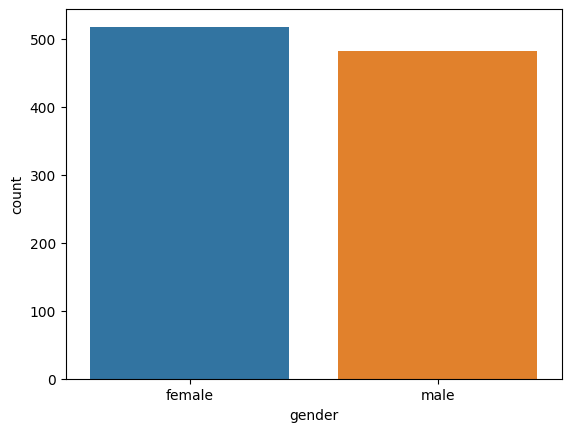

In [23]:
ax = sns.countplot(x="gender", data=dataset)

In [24]:
ax = sns.countplot(x="race/ethnicity", data=dataset)

In [25]:
ax = sns.countplot(y="parental level of education", data=dataset)

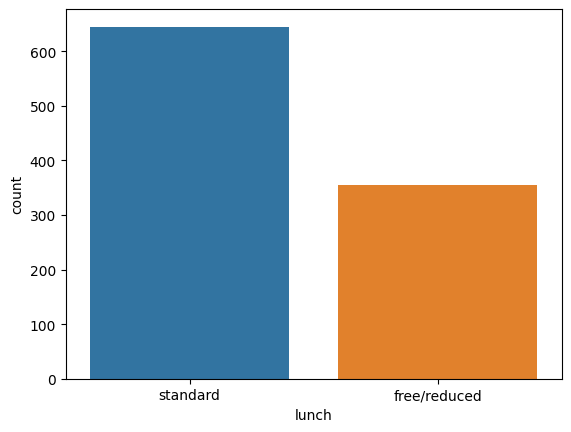

In [26]:
ax = sns.countplot(x="lunch", data=dataset)

In [27]:
ax = sns.countplot(x="test preparation course", data=dataset)

In [28]:
ax = sns.distplot(dataset["math score"]);

/Users/suziyang/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


### Data Processing

Lets create a new feature, named as math grade. Math grade is Pass if math score is above 60, math grade Fail if math score is below 60. It is just an assumption. After creating the new column, I have removed the unneccasry columns and check the latest form of dataset again.

#### *Hint: it is a good example for changing some rows of a column according to some conditional expressions on values of other columns. 

In [29]:
dataset["math grade"] = ""
dataset.loc[(dataset["math score"] >= 60), "math grade"] = "Pass"
dataset.loc[(dataset["math score"] < 60), "math grade"] = "Fail"
dataset.drop(columns=['math score', 'reading score', 'writing score'], inplace=True)
dataset.head()

gender race/ethnicity parental level of education         lunch  \
0  female        group B           bachelor's degree      standard   
1  female        group C                some college      standard   
2  female        group B             master's degree      standard   
3    male        group A          associate's degree  free/reduced   
4    male        group C                some college      standard   

  test preparation course math grade  
0                    none       Pass  
1               completed       Pass  
2                    none       Pass  
3                    none       Fail  
4                    none       Pass

### One Hot Encoding

#### *Hint: One hot encoding is necessary if you use scikit-learn library for modelling. 

Scikit-learn uses only numerical features and these numerical features are considered as continuos numeric values. In our case race feature includes group A, group B, group C, group D, group E and it will be encoded as 1,2,3,4,5 under one column if you use just label encoding not one hot encoding. Till now everything is fine but problem starts here. Since model assumes that all numerical values are continuous, you will see such internal nodes (splitting point): "race < 4 which means group A race < group B race" which is very weird. Weird because there is no continouity among race values. It would be the same if our feature was color. It may be acceptable for parental level of education if you set the order correctly because there is a continuity. Of course master's degree is higher than bachelor's degree and it is higher than some college etc. That is why we have to apply one hot encoding if we use scikit-learn. 

#### *Hint: Dropping one of the one hot encoded columns are a good approach otherwise weigths and effects of features over the model may be higher or lower. 

Assume that in our dataset we have only age and gender features. Since age is continous numeric variable that is good for scikit-learn but we have to apply one hot encoding for gender. After applying it we have 3 features, age, gender_male, gender_female. Lets give an example, lets say our person is male so as values gender_male is 1 and gender_female is 0 and lets say age is 20. That sounds ok but not actually. Lets say you are talking with the model and you check age feature and tell "this person is 20 years old". And then you check gender_male feature and tell "this person is male". And then you check gender_female column and tell "this person is not a female (which means person is a male)". Just to tell the model once about the person's gender, you have to drop one of the one hot encoded columns and drop_first=True makes it for us.


In [30]:
one_hot = pd.get_dummies(dataset['gender'], prefix='gender', drop_first=True)
dataset = dataset.join(one_hot)
one_hot = pd.get_dummies(dataset['race/ethnicity'], prefix='race/ethnicity', drop_first=True)
dataset = dataset.join(one_hot)
one_hot = pd.get_dummies(dataset['parental level of education'], prefix='parental level of education', drop_first=True)
dataset = dataset.join(one_hot)
one_hot = pd.get_dummies(dataset['lunch'], prefix='lunch', drop_first=True)
dataset = dataset.join(one_hot)
one_hot = pd.get_dummies(dataset['test preparation course'], prefix='test preparation course', drop_first=True)
dataset = dataset.join(one_hot)
dataset.head()

gender race/ethnicity parental level of education         lunch  \
0  female        group B           bachelor's degree      standard   
1  female        group C                some college      standard   
2  female        group B             master's degree      standard   
3    male        group A          associate's degree  free/reduced   
4    male        group C                some college      standard   

  test preparation course math grade  gender_male  race/ethnicity_group B  \
0                    none       Pass            0                       1   
1               completed       Pass            0                       0   
2                    none       Pass            0                       1   
3                    none       Fail            1                       0   
4                    none       Pass            1                       0   

   race/ethnicity_group C  race/ethnicity_group D  race/ethnicity_group E  \
0                       0                       0                       0   
1                       1                       0                       0   
2                       0                       0                       0   
3                       0                       0                       0   
4                       1                       0                       0   

   parental level of education_bachelor's degree  \
0                                              1   
1                                              0   
2                                              0   
3                                              0   
4                                              0   

   parental level of education_high school  \
0                                        0   
1                                        0   
2                                        0   
3                                        0   
4                                        0   

   parental level of education_master's degree  \
0                                            0   
1                                            0   
2                                            1   
3                                            0   
4                                            0   

   parental level of education_some college  \
0                                         0   
1                                         1   
2                                         0   
3                                         0   
4                                         1   

   parental level of education_some high school  lunch_standard  \
0                                             0               1   
1                                             0               1   
2                                             0               1   
3                                             0               0   
4                                             0               1   

   test preparation course_none  
0                             1  
1                             0  
2                             1  
3                             1  
4                             1

### Train - Test Split

Splitting the dataset into two datasets as train, test and blind hold-out datasets. The ratio is 70/20/10. 

#### *Hint: Seperating and keeping blind hold out dataset is an important concept. Since we try to tune the model by using train and test datasets, it is possible that at a certain point model can overfit to test dataset even. That is why keeping a blind hold out dataset and use it very very often, only when we think that our model is tuned and works very well.

#### *Hint: random_state parameter is used if you want to have exactly the same train and test datasets and if you don't want them to be different in every splitting when you run your notebook from the beginning. It doesn't matter which number, you can set 5, 77, 100 whatever. The only important point is to set the same number. For me it is 21 in this case.

In [31]:
data_train, data_test_hold = train_test_split(dataset, test_size=0.30, random_state=21)
data_test, data_hold = train_test_split(data_test_hold, test_size=0.33, random_state=21)

### Create Numerical Arrays for the Model

In [32]:
columns_move = ["gender", "race/ethnicity", "parental level of education", "lunch", "test preparation course", "gender_male", "race/ethnicity_group B", "race/ethnicity_group C", "race/ethnicity_group D", "race/ethnicity_group E", "parental level of education_bachelor's degree", "parental level of education_high school", "parental level of education_master's degree", "parental level of education_some college", "parental level of education_some high school", "lunch_standard", "test preparation course_none"]

In [33]:
y_train = data_train["math grade"].values
X_train = data_train[columns_move].values
y_test = data_test["math grade"].values
X_test = data_test[columns_move].values

### Create the Model

There is no tuning for the model. It is created with the default values of the DecisionTreeClassifier. That is why it will be very very big overfitting decision tree :).

In [34]:
model = DecisionTreeClassifier(criterion='gini', splitter='best', 
                               max_depth=None, min_samples_split=2, 
                               min_samples_leaf=1, min_weight_fraction_leaf=0.0, 
                               max_features=None, random_state=None, 
                               max_leaf_nodes=None, min_impurity_decrease=0.0, 
                               class_weight=None)

### Training the Model

In [35]:
model.fit(X_train[:,5:], y_train)

DecisionTreeClassifier()

### Predictions

In [36]:
y_pred = model.predict(X_test[:,5:])

In [37]:
print("Model Accuracy: %.2f" % (accuracy_score(y_test,y_pred)*100), "%")

Model Accuracy: 56.72 %


In [38]:
a = pd.DataFrame(confusion_matrix(y_test,y_pred), columns=['prediction/fail', 'prediction/pass'], index=['actual/fail', 'actual/pass'])
print("Confusion Matrix:")
print(a)

Confusion Matrix:
             prediction/fail  prediction/pass
actual/fail               27               41
actual/pass               46               87


In [39]:
print("Classification Report:")
print("")
print(classification_report(y_test,y_pred))

Classification Report:

              precision    recall  f1-score   support

        Fail       0.37      0.40      0.38        68
        Pass       0.68      0.65      0.67       133

    accuracy                           0.57       201
   macro avg       0.52      0.53      0.52       201
weighted avg       0.57      0.57      0.57       201



Model accuracy is 56%. As all we know, it is never enough to check only accuracy so lets see how we can get a confusion matrix, precision, recall and f1 scores by using scikit-learn library. 

There are so many resources explain these concepts. I can advice the article "Accuracy, Precision, Recall or F1?" by Koo Ping Shung. Here is the link: https://towardsdatascience.com/accuracy-precision-recall-or-f1-331fb37c5cb9

Lets make predictions by using the train dataset and compare it with the results from test set. The purpose is to check whether there is an overfitting or not. As I said at the beginning, 56% and 80% are quite different from each other, 56% is almost a flip-coin, on the other hand 80% is a promising accuracy rate. 

In [40]:
y_pred_train = model.predict(X_train[:,5:])

In [41]:
print("Model Accuracy: %.2f" % (accuracy_score(y_train,y_pred_train)*100), "%")

Model Accuracy: 79.86 %


### Combined Result Data Frame with Predictions

In [43]:
columns_move.append("math grade test")
columns_move.append("math grade pred")

In [44]:
y_pred = y_pred.reshape(len(y_pred),1)
y_test = y_test.reshape(len(y_test),1)
resultarray = np.append(X_test, y_test, axis=1)
resultarray = np.append(resultarray, y_pred, axis=1)
resultdf = pd.DataFrame(resultarray, columns=columns_move)

In [45]:
resultdf.drop(columns=["gender_male", "race/ethnicity_group B", "race/ethnicity_group C", "race/ethnicity_group D", "race/ethnicity_group E", "parental level of education_bachelor's degree", "parental level of education_high school", "parental level of education_master's degree", "parental level of education_some college", "parental level of education_some high school", "lunch_standard", "test preparation course_none"], inplace=True)
resultdf.head(200)

gender race/ethnicity parental level of education         lunch  \
0      male        group C          associate's degree  free/reduced   
1    female        group C                 high school      standard   
2      male        group B           bachelor's degree  free/reduced   
3      male        group D                some college      standard   
4      male        group A            some high school  free/reduced   
..      ...            ...                         ...           ...   
195  female        group B                 high school  free/reduced   
196    male        group D            some high school  free/reduced   
197    male        group B            some high school      standard   
198    male        group B                some college  free/reduced   
199  female        group C            some high school  free/reduced   

    test preparation course math grade test math grade pred  
0                      none            Fail            Pass  
1                      none            Pass            Pass  
2                      none            Pass            Pass  
3                 completed            Pass            Pass  
4                      none            Fail            Pass  
..                      ...             ...             ...  
195               completed            Fail            Pass  
196                    none            Pass            Fail  
197               completed            Fail            Pass  
198               completed            Pass            Fail  
199                    none            Pass            Fail  

[200 rows x 7 columns]